In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
seed = 45

train_path = 'train.csv'
# test_path = 'optiver-trading-at-the-close/test.csv'

# Load into DataFrame
df_train = pd.read_csv(train_path)

In [3]:
df_train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [4]:
def preprocess(df):
    """
    Absolute bare minimal preprocessing for the Optiver dataset
    """

    # Fill NaNs in near_price and far_price with reference_price
    df['near_price'] = df['near_price'].fillna(df['reference_price'])
    df['far_price'] = df['far_price'].fillna(df['reference_price'])
    df['wap'] = df['wap'].fillna(df['reference_price'])
    
    # Subtract mean from price features, grouped by stock_id
    price_features = ['ask_price', 'bid_price', 'near_price', 'far_price', 'reference_price', 'wap']
    for feature in price_features:
        df[feature] = df.groupby('stock_id')[feature].transform(lambda x: x - x.mean())

    # Drop row_id and time_id, not needed for training
    df = df.drop(['row_id', 'time_id'], axis=1).dropna()
    targets = df['target']
    df = df.drop(['target'], axis=1)
    return df, targets

In [ ]:
def preprocess_test(df):
    """
    Preprocess test data similarly to training data
    """
    df['near_price'] = df['near_price'].fillna(df['reference_price'])
    df['far_price'] = df['far_price'] = df['reference_price']
    df['wap'] = df['wap'].fillna(df['reference_price'])

In [5]:
X_train, y_train = preprocess(df_train)

In [6]:
def plot_moving_average(df, feature, stock_id):
    """
    Plots the 5-day moving average of a feature for a given stock_id.
    The average at each date_id is computed over date_id in [curr, curr+5].
    """
    # Filter for the given stock_id
    stock_df = df[df['stock_id'] == stock_id].copy()
    stock_df = stock_df.sort_values('date_id')
    
    # Group by date_id and compute mean for each day
    daily_means = stock_df.groupby('date_id')[feature].mean().reset_index()
    
    # Compute moving average over 5 days (window includes curr and next 4 days)
    daily_means['moving_avg'] = daily_means[feature].rolling(window=5, min_periods=1).mean().shift(-4)
    
    print('Average over all dates:', daily_means[feature].mean())
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(daily_means['date_id'], daily_means[feature], label=f'Daily mean {feature}')
    plt.plot(daily_means['date_id'], daily_means['moving_avg'], label='5-day moving average', linewidth=2)
    plt.xlabel('date_id')
    plt.ylabel(feature)
    plt.title(f'5-Day Moving Average of {feature} for stock_id {stock_id}')
    plt.legend()
    plt.show()

Average over all dates: 1.0917217118772127e-16


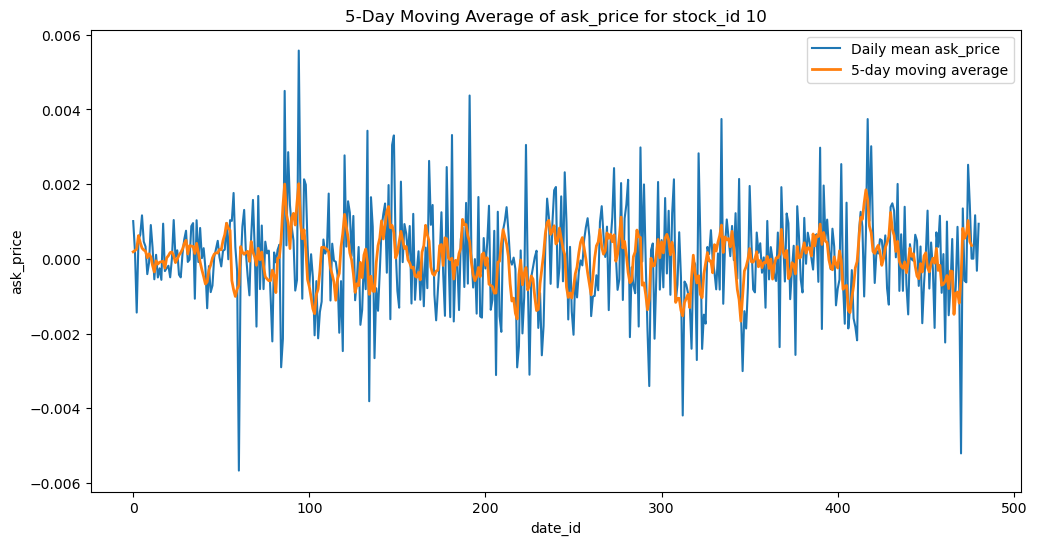

In [7]:
plot_moving_average(X_train, 'ask_price', 10)

In [8]:
X_train.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap'],
      dtype='object')

In [52]:
ts_features = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'near_price', 'wap']
timestamps = X_train['seconds_in_bucket'].unique()
dates = X_train['date_id'].unique()
stocks = X_train['stock_id'].unique()

batches = []
seq_len = 11
counter = 0
for stock in stocks:
    for date in dates:
        if counter == 0:
            temp_df = X_train.query(f'stock_id == {int(stock)} and date_id == {int(date)}').sort_values('seconds_in_bucket').copy()
            batches.append([temp_df.iloc[i:i+seq_len] for i in range(0, len(temp_df), seq_len)])
            del temp_df
        counter += 1

In [34]:
# --------------------
# Model Definition
# --------------------
class OptiverModel(nn.Module):
    def __init__(self, 
                 n_stocks = 200,  
                 stock_emb_dim=3, 
                 date_emb_dim=2, 
                 lstm_input_dim=7, 
                 lstm_hidden_dim=32, 
                 lstm_layers=2, 
                 forecast_horizon=6):
        super().__init__()
        
        self.meta_fc = nn.Sequential(
            nn.Linear(2, 4),  # stock_id and date_id as raw floats/ints
            nn.ReLU()
        )

        
        # LSTM for historical time-series features
        self.lstm = nn.LSTM(input_size=lstm_input_dim,
                            hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers,
                            batch_first=True)
        
        # Project LSTM last hidden state to forecast horizon × feature_dim
        self.lstm_out = nn.Linear(lstm_hidden_dim, forecast_horizon * lstm_input_dim)
        self.forecast_horizon = forecast_horizon
        self.lstm_input_dim = lstm_input_dim
        
        # Final fully connected layer: fuse metadata + forecast (+6 step only)
        fused_dim = 4 + lstm_input_dim
        self.final_fc = nn.Sequential(
            nn.Linear(fused_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # predict target
        )

    def forward(self, stock_id, date_id, ts_features):
        """
        stock_id: (batch,)
        date_id: (batch,)
        ts_features: (batch, seq_len, lstm_input_dim)
        """
        # Embedding features

        # Ensure inputs are float (if needed)
        stock_date = torch.stack([stock_id, date_id], dim=1)  # shape (batch, 2)
        meta_vec = self.meta_fc(stock_id)  # (batch, 4)

        
        # LSTM forecast
        lstm_out, _ = self.lstm(ts_features)         # (batch, seq_len, hidden_dim)
        last_hidden = lstm_out[:, -1, :]              # take last time step
        forecast = self.lstm_out(last_hidden)         # (batch, horizon * input_dim)
        forecast = forecast.view(-1, self.forecast_horizon, self.lstm_input_dim)
        forecast_6 = forecast[:, -1, :]               # only +6 step
        
        # Fuse metadata with +6 step forecast
        fused = torch.cat([meta_vec, forecast_6], dim=-1)
        target_pred = self.final_fc(fused)            # (batch, 1)
        
        return target_pred


In [7]:
# --------------------
# Example Dataset
# --------------------
class OptiverDataset(Dataset):
    def __init__(self, stock_ids, date_ids, ts_data, targets):
        self.stock_ids = stock_ids
        self.date_ids = date_ids
        self.ts_data = ts_data
        self.targets = targets
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return (self.stock_ids[idx],
                self.date_ids[idx],
                self.ts_data[idx],
                self.targets[idx])

In [35]:
model = OptiverModel()

In [36]:
model.forward(0, 0, torch.randn(1, 10, 7))  # Example forward pass with dummy data

TypeError: expected Tensor as element 0 in argument 0, but got int

In [8]:
# --------------------
# Training / Validation Loop
# --------------------
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cuda'):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for stock_id, date_id, ts_features, target in train_loader:
            stock_id = stock_id.to(device)
            date_id = date_id.to(device)
            ts_features = ts_features.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(stock_id, date_id, ts_features)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * stock_id.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for stock_id, date_id, ts_features, target in val_loader:
                stock_id = stock_id.to(device)
                date_id = date_id.to(device)
                ts_features = ts_features.to(device)
                target = target.to(device)
                output = model(stock_id, date_id, ts_features)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item() * stock_id.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.5f}, Val Loss: {avg_val_loss:.5f}")

    return model

In [ ]:
# --------------------
# Usage Example
# --------------------
if __name__ == "__main__":
    n_samples = df_train.shape[0]
    n_stocks = df_train['stock_id'].nunique()
    n_dates = df_train['date_id'].nunique()
    seq_len = 20
    lstm_input_dim = 7
    
    stock_ids = df_train['stock_id']
    date_ids = df_train['date_id']
    ts_data = df_train[['seconds_in_bucket', 'imbalance_size', 'reference_price', 'near_price', 'far_price', 'bid_size', 'ask_size']].groupby(['stock_id', 'date_id'])
    targets = df_train['target']

    dataset = OptiverDataset(stock_ids, date_ids, ts_data, targets)
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset, batch_size=64)

    model = OptiverModel(n_stocks, n_dates)
    trained_model = train_model(model, train_loader, val_loader, epochs=5, lr=1e-3, device='cpu')

KeyError: 1983093

In [19]:
grouped = df_train.groupby(['stock_id', 'date_id'])

In [20]:
grouped.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.999812,0.999812,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.999896,0.999896,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.999561,0.999561,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0
3,3,0,0,11917682.27,-1,1.000171,18389745.62,1.000171,1.000171,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.999532,0.999532,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5227975,195,480,40,3130941.73,-1,0.999618,7982627.83,0.999618,0.999618,0.999618,11144.90,0.999851,8575.00,0.999750,4.099608,26404
5227976,196,480,40,3736214.80,-1,1.000386,2838284.84,1.000386,1.000386,1.000386,42489.72,1.000643,25881.80,1.000545,10.260344,26404
5227977,197,480,40,1433561.86,-1,1.000287,3831440.32,1.000287,1.000287,1.000287,44514.75,1.000474,47192.34,1.000378,-2.130270,26404
5227978,198,480,40,3654927.55,1,1.000173,62253465.86,1.000173,1.000173,0.999933,109722.26,1.000173,214387.94,1.000014,2.269745,26404
